In [30]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

Text(0, 0.5, 'x, v')

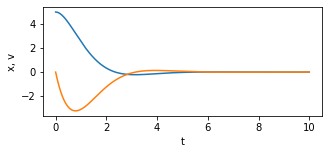

In [31]:
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

k = 2
b = 2
x0 = [5,0]
t = np.linspace(0,10,2000)
sol = odeint(fun, x0, t)

plt.figure(figsize=(5,2));
plt.plot(t,sol);
plt.xlabel('t')
plt.ylabel('x, v')

In [32]:
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)

# Distributions Parameters
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.4

# Compute P_space and P_time 
N = 40
u = np.linspace(-10,10,N)
v = np.linspace(-10,10,N)
T = np.linspace(0,10,N)
U,V = np.meshgrid(u,v)
#
P = np.zeros((N,N))
P_exp = np.zeros((N,1))
for i in range(N):
    for j in range(N):
        x = np.array([U[i,j],V[i,j]])
        P[i,j] = multivariate_normal.pdf(x,mu,Sigma)
    P_exp[i] = CumExpDist(T[i],tau)
    

# Compute Total Probability
X = -5 + 10*np.random.rand(10000,2)
X = np.hstack((X,5*np.random.rand(10000,1)))
#
P_tot = [multivariate_normal.pdf(x[:2],mu,Sigma)*CumExpDist(x[2],tau) for x in X]

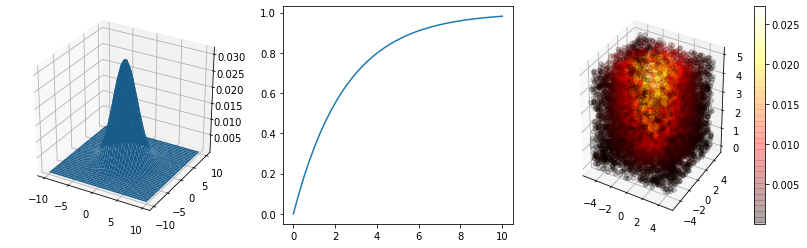

In [33]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(U, V, P)
ax2 = fig.add_subplot(132)
ax2.plot(T, P_exp)
ax3 = fig.add_subplot(133, projection='3d')
density = ax3.scatter(X[:,0], X[:,1], X[:,2], c=P_tot, cmap=plt.hot(), alpha = 0.2)
fig.colorbar(density)

In [5]:
#
p_sol = np.array([multivariate_normal.pdf(sol[i],mu,Sigma) for i in range(len(sol))])#np.array([SpatialExpDist(sol[i],0.01) for i in range(len(sol))])#
p_t = np.array([CumExpDist(t[i],0.2) for i in range(len(sol))])
P = np.multiply(p_sol,p_t)

In [6]:
Event_flag = np.array([np.random.binomial(1,P[i]) for i in range(len(sol))])

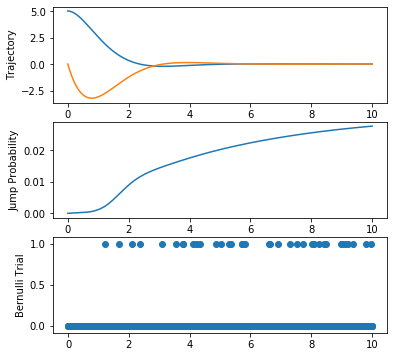

In [7]:
plt.figure(figsize=(6,6))
plt.subplot(311)
plt.plot(t,sol)
plt.ylabel('Trajectory')
plt.subplot(312)
plt.plot(t,P)
plt.ylabel('Jump Probability')
plt.subplot(313)
plt.ylabel('Bernulli Trial')
plt.scatter(t,Event_flag)

In [8]:
Event_index = []
for i in range(len(Event_flag)):
    if Event_flag[i]>0:
        Event_index.append(i)
Event_states = sol[Event_index]

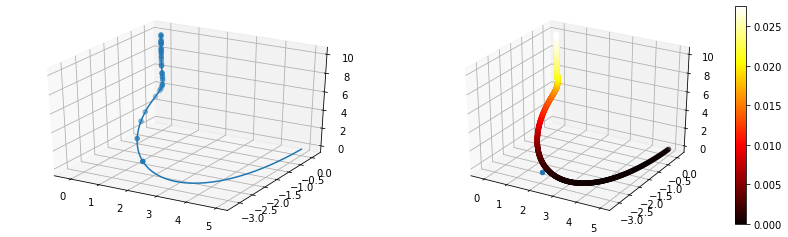

In [9]:
import matplotlib
cmap = matplotlib.cm.get_cmap('hot')
normalize = matplotlib.colors.Normalize(vmin=min(P), vmax=max(P))
colors = [cmap(normalize(value)) for value in P]

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(sol[:,0],sol[:,1],t)
ax1.scatter(Event_states[:,0],Event_states[:,1], t[Event_index].reshape(-1,1))
#
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(sol[:,0], sol[:,1], t.reshape(-1,1), color=colors)
ax2.scatter(Event_states[0,0],Event_states[0,1])
cax, _ = matplotlib.colorbar.make_axes(ax2)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)


In [10]:
#jump map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

from pyPDMP.utils import HDSint
Ttot, Xtot, Xevent, Xreset, C = HDSint(5000,t,fun,x0,mu,Sigma,tau)

Progress:
25.0
50.0
75.0
100.0


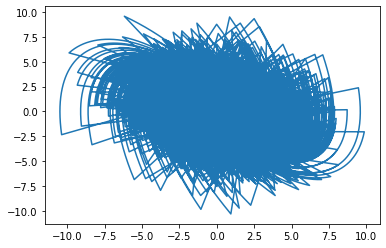

In [11]:
plt.figure()
plt.plot(Xtot[1:,0],Xtot[1:,1]);
plt.scatter(Xevent[1:,0],Xevent[1:,1]);

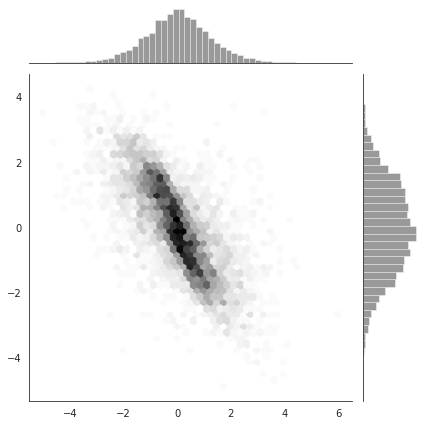

In [12]:
with sns.axes_style("white"):
    sns.jointplot(x=Xevent[:,0], y=Xevent[:,1], kind="hex", color="k");

Text(0.5, 0, 'event time')

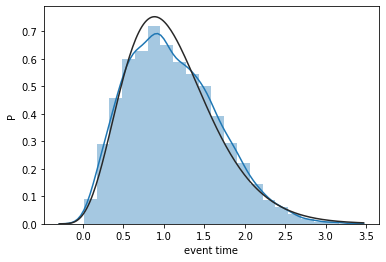

In [13]:
from scipy.stats import norm
from scipy.stats import gamma
plt.figure()
sns.distplot(Xevent[1:,2],bins = 20, fit = gamma);
plt.ylabel('P')
plt.xlabel('event time')

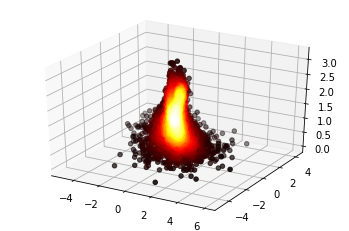

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
x = Xevent[1:,0]
y = Xevent[1:,1]
z = Xevent[1:,2]

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density,cmap=plt.hot())
plt.draw()
plt.show()

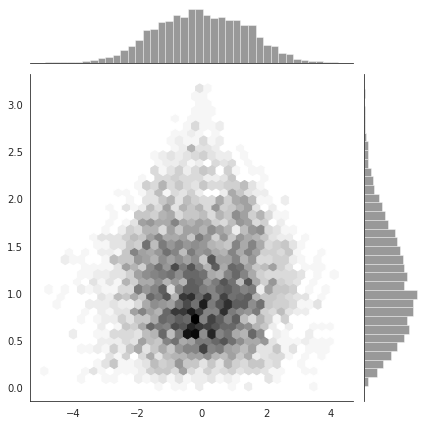

In [15]:
with sns.axes_style("white"):
        sns.jointplot(x=Xevent[1:,1], y=Xevent[1:,2], kind="hex", color="k");

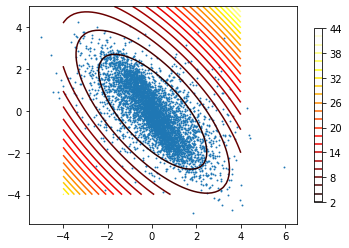

In [16]:
from matplotlib.colors import LogNorm
from sklearn import mixture

# Fit mixure of gaussian
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
clf.fit(np.hstack((Xevent[:,0].reshape(-1,1),Xevent[:,1].reshape(-1,1))))

x = np.linspace(-4., 4.)
y = np.linspace(-4., 5.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure()
CS = plt.contour(X, Y, Z,20)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(Xevent[1:,0], Xevent[1:,1], .8)
plt.show()

In [17]:
np.hstack((Xevent[:,0].reshape(-1,1),Xevent[:,2].reshape(-1,1)))

array([[ 1.9758011 ,  1.1905953 ],
       [ 1.23955012,  1.66083042],
       [-1.21172836,  1.36068034],
       ...,
       [-1.30719725,  1.1805903 ],
       [-3.54549496,  0.54527264],
       [-0.42390938,  0.10505253]])

In [18]:
#x_event.mean(0)
Se = Xevent[:,:3].T.dot(Xevent[:,:3])/len(Xevent)
Se

array([[ 1.50176855, -1.19404533,  0.02423628],
       [-1.19404533,  1.90918029, -0.04448113],
       [ 0.02423628, -0.04448113,  1.53597224]])

In [19]:
DXtot = [0]
i = len(Xtot)-1
while i>0:
    if Ttot[i]-Ttot[i-1] == 0:
        Ttot_r = np.delete(Ttot,i-1)
        Xtot_r = np.delete(Xtot,i-1,axis = 0)
        print(i)
    i -= 1

1106758
1106649
1106413
1106286
1105903
1105706
1105524
1105308
1104929
1104458
1104398
1104284
1104244
1103766
1103553
1103361
1103227
1103069
1102439
1102158
1101957
1101807
1101669
1101563
1101337
1101281
1100985
1100736
1100592
1100554
1100287
1100197
1099961
1099741
1099347
1099154
1099035
1098846
1098732
1098544
1098216
1097917
1097554
1097330
1097168
1096765
1096404
1096209
1096119
1095980
1095818
1095744
1095455
1095207
1095070
1094762
1094374
1094274
1094023
1093805
1093623
1093341
1093177
1092945
1092903
1092764
1092733
1092643
1092240
1092108
1091609
1091371
1091160
1090910
1090601
1090312
1090093
1090017
1089828
1089582
1089436
1089243
1088997
1088866
1088733
1088486
1088029
1087565
1087546
1087349
1087107
1086959
1086811
1086499
1086171
1086078
1085963
1085692
1085541
1085054
1085007
1084635
1084311
1084057
1083874
1083825
1083630
1083495
1083292
1083128
1082698
1082615
1082392
1082227
1082145
1082014
1081712
1081591
1081585
1081514
1081266
1081152
1080927
1080670
1080540


861653
861257
860997
860803
860559
860159
859643
859406
859363
858946
858736
858663
858316
858218
858021
857933
857532
857147
856801
856387
856372
855957
855535
855468
855011
854828
854734
854621
854380
854227
854076
853723
853537
853214
853034
852844
852545
852431
852296
852029
852026
851671
851516
851151
850865
850617
850485
850086
849849
849801
849618
849492
849126
848871
848569
848479
848134
847952
847620
847271
847081
846875
846847
846538
846137
845994
845686
845489
845364
845160
844985
844750
844556
844476
844267
844171
843956
843656
843552
843320
843202
842837
842716
842518
842287
841910
841802
841785
841550
841284
841188
841021
840664
840289
840001
839691
839583
839281
838973
838863
838581
838473
838160
837937
837557
837447
837237
837187
836877
836685
836585
836457
836209
835943
835857
835773
835661
835377
834970
834752
834379
834257
834244
834137
833940
833650
833566
833354
833157
833017
832811
832461
832342
831939
831644
831375
831177
830939
830712
830460
830153
829729
829658

602183
601983
601755
601633
601261
601013
600915
600838
600329
600209
600017
599916
599597
599249
598952
598828
598592
598590
598294
597964
597812
597602
597513
597353
597182
597008
596898
596513
596323
596112
596018
595674
595363
595332
595045
594722
594452
594315
594160
593899
593720
593604
593403
593374
593108
592943
592659
592291
591876
591710
591370
591051
590991
590795
590597
590420
590264
589636
589509
589339
589182
588925
588699
588197
587962
587791
587661
587313
587159
586997
586872
586738
586302
586131
585739
585523
585382
585059
584845
584673
584370
584250
584120
583693
583527
583047
582873
582774
582415
582174
581951
581832
581633
581394
581307
581141
580672
580584
580454
580368
580210
579900
579759
579520
579159
578667
578343
578065
577784
577557
577330
577221
577179
577112
576993
576761
576684
576374
575960
575443
575153
574958
574671
574442
574264
573999
573964
573701
573427
573098
572862
572780
572699
572369
571963
571731
571591
571380
571052
570775
570523
570434
570361

341729
341664
341457
341165
340999
340905
340603
340301
340019
339628
339499
339229
338964
338805
338702
338583
338214
338147
338007
337549
337474
337311
337184
336792
336369
336239
336102
335912
335726
335419
334997
334839
334710
334401
334136
334089
333951
333568
333013
332805
332442
332133
331900
331826
331726
331508
331056
330780
330543
330388
330211
330057
329773
329447
329270
328642
328343
328180
327900
327677
327442
327281
326992
326552
326347
326164
325714
325520
325471
325169
324963
324537
324164
323869
323725
323635
323355
323165
323055
322479
322258
322162
322068
321707
321637
321225
321066
320810
320522
320442
320241
319682
319458
319294
319036
318775
318683
318381
318084
317988
317943
317535
317447
317298
317008
316926
316744
316612
316240
316117
315971
315935
315751
315577
315491
315030
314843
314428
314321
313956
313573
313504
313128
312926
312768
312347
311838
311570
311465
311070
310767
310579
310419
310372
310236
310150
309813
309553
309125
309039
308910
308520
308130

73633
73553
73373
72965
72772
72606
72387
72103
71961
71694
71406
71344
71189
70899
70598
70487
70144
69961
69867
69650
69445
69335
68987
68876
68736
68461
68113
67716
67447
67266
67031
66849
66669
66422
66340
66233
66016
65760
65680
65489
65322
65204
64897
64745
64498
64286
64042
63777
63504
63263
63187
62903
62523
62390
62197
61988
61888
61472
61244
60795
60417
60151
59838
59794
59480
59418
59257
58743
58585
58366
58331
58030
58000
57840
57729
57610
57482
57194
56899
56478
56093
55962
55909
55731
55378
55247
54864
54649
54418
53942
53503
53238
52815
52773
52640
52251
52174
52030
51844
51825
51751
51278
50913
50455
50363
49955
49859
49736
49616
49365
49216
48776
48503
48315
48108
47893
47549
47486
47174
46946
46657
46451
46237
45941
45868
45590
45508
45274
44893
44767
44732
44603
44394
44144
43793
43519
43399
43217
42981
42794
42625
42422
42361
42150
41896
41442
41361
40915
40671
40634
40469
40286
40094
39677
39527
39332
39042
38755
38620
38308
38031
37920
37806
37668
37496
37269
3724

In [20]:
def SmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/2


DeltaXtot = (Xtot_r[1:]-Xtot_r[:-1])/(Ttot[1]-Ttot[0])
DXtot = [np.linalg.norm(p) for p in DeltaXtot]

r = 2
S_b = [SmoothnessBound(Xtot[i],Xtot[i-1],r) for i in range(2,len(Xtot))]

(0, 100)

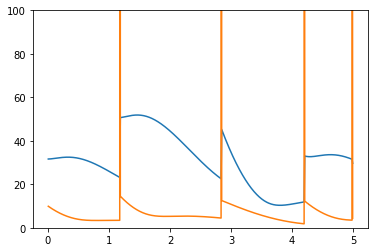

In [21]:
plt.figure()
plt.plot(t[1:999],S_b[1:999])
plt.plot(t[1:999],DXtot[1:999])
plt.ylim([0,100])

## Noisy
we add Gaussian noise on the observations of the state but on the time

In [22]:
noise_std = 0.05
Xtot_r_noisy = Xtot_r + noise_std*np.hstack((np.random.rand(len(Xtot_r),2),np.zeros((len(Xtot_r),1)))) 

DeltaXtot_noisy = (Xtot_r_noisy[1:]-Xtot_r_noisy[:-1])/(Ttot[1]-Ttot[0])
DXtot_noisy = np.array([np.linalg.norm(p) for p in DeltaXtot_noisy])

In [23]:
def NormSmoothnessBound(x, x_, r):
    Df = [[0, 1, 0], [-k, -b, 0], [0, 0, 1]]
    nDf = np.linalg.norm(Df)
    Integral = np.linalg.norm(x)+np.linalg.norm(x_)
    return (r*nDf*Integral)/(2)

r = 15
S_b_noisy = np.array([SmoothnessBound(Xtot_r_noisy[i],Xtot_r_noisy[i-1],r) for i in range(1,len(Xtot_r_noisy))])

In [24]:
def JumpDetector(Dx,Sb):
    if Dx<=Sb:
        return 0
    else:
        return 1
    
gamma = [JumpDetector(DXtot_noisy[i],S_b_noisy[i]) for i in range(len(DXtot_noisy))]

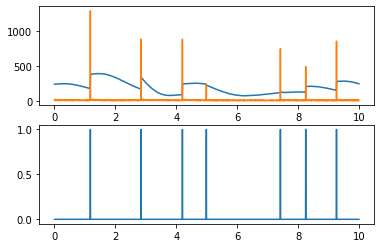

In [25]:
plt.figure()
plt.subplot(211)
plt.plot(t[1:1999],S_b_noisy[1:1999])
plt.plot(t[1:1999],DXtot_noisy[1:1999])
plt.subplot(212)
plt.plot(t[1:1999],gamma[1:1999])
#plt.ylim([0,100])

## Normalizing Flows

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.multivariate_normal import MultivariateNormal

In [164]:
class Planar(nn.Module):
    """
    Planar Normalizing Flow
    
    Computes the following transformation:
        z' = z + u h( w^T z + b)
        or actually
        z'^T = z^T + h(z^T w + b)u^T
        Assumes the following input shapes:
        shape u = (batch_size, z_size, 1)
        shape w = (batch_size, 1, z_size)
        shape b = (batch_size, 1, 1)
        shape z = (batch_size, z_size).
    """
    def __init__(self, bsize, zsize):

        super(Planar, self).__init__()
        
        self.bsize = bsize
        self.zsize = zsize
        self.h = nn.Tanh()
        self.softplus = nn.Softplus()
        
        self.u = nn.Parameter(data=torch.zeros(bsize, zsize, 1), requires_grad=True)
        self.w = nn.Parameter(data=torch.zeros(bsize, 1, zsize), requires_grad=True)
        self.b = nn.Parameter(data=torch.zeros(bsize, 1, 1), requires_grad=True)
        
        # apply inits to u, w, b tensors
        self.p = [self.u, self.w]
        for params in self.p:
            self.apply_weight_init(params, 'kaiming_normal')
        
    def apply_weight_init(self, tensor, init_method=None):
        if init_method is None:
            pass  # do not apply weight init
        elif init_method == "normal":
            torch.nn.init.normal_(tensor, std=0.3)
        elif init_method == "kaiming_normal":
            torch.nn.init.kaiming_normal_(tensor)
        
    def der_h(self, x):
        """ Derivative of tanh """
        return 1 - self.h(x) ** 2

    def forward(self, zk):
        """
        Forward pass. Assumes amortized u, w and b. Conditions on diagonals of u and w for invertibility
        will be be satisfied inside this function. 
        """
        zk = zk.view(self.bsize, self.zsize, 1)

        # reparameterize u such that the flow becomes invertible (see appendix paper)
        uw = torch.bmm(self.w, self.u)
        m_uw = -1. + self.softplus(uw)
        w_norm_sq = torch.sum(self.w ** 2, dim=2, keepdim=True)
        u_hat = self.u + ((m_uw - uw) * self.w.transpose(2, 1) / w_norm_sq)

        # compute flow with u_hat
        wzb = torch.bmm(self.w, zk) + b
        z = zk + u_hat * self.h(wzb)
        z = z.squeeze(2)

        # compute logdetJ
        psi = self.w * self.der_h(wzb)
        log_det_jacobian = torch.log(torch.abs(1 + torch.bmm(psi, u_hat)))
        log_det_jacobian = log_det_jacobian.squeeze(2).squeeze(1)

        return z, log_det_jacobian

### Prior distrib for z

In [166]:
mu = torch.zeros(3)
var = 0.3*torch.eye(3)

In [167]:
prior = MultivariateNormal(mu, var)
z = prior.sample([1])
m = Planar(1, 3)
m

Planar(
  (h): Tanh()
  (softplus): Softplus(beta=1, threshold=20)
)

In [168]:
m(z)

(tensor([[ 1.9288, -0.1726,  0.5531]], grad_fn=<SqueezeBackward1>),
 tensor([-0.0309], grad_fn=<SqueezeBackward1>))

## Planar Flow

Start with random vector $$z_0 \sim q_0$$
Apply invertible transformations and obtain $$z_k = f_k \circ f_{k-1} \circ \cdots \circ f_1(z_0)$$ 
The distribution of $$z_k$$ is given by: $$q_k(z_k) = q_0(f_1^{-1} \circ f_2^{-1} \circ \cdots \circ \circ f_k^{-1}(z_k))\prod_{i=1}^{k}|det(J_{i}(z_{i-1})|^{-1}$$

where $$J_{i}$$ is the Jacobian of ith normalizing flow

A planar normalizing flow is defined by invertible transformation of the type: $$z' = z + u h( w^T z + b)$$

We can start with $$q_0 = \mathcal{N}(0, \mathcal{I})$$

In [424]:
mu = torch.zeros(3)
var = torch.eye(3)
q0 = MultivariateNormal(mu, var)

In [425]:
m = Planar(100, 3)
m

Planar(
  (h): Tanh()
  (softplus): Softplus(beta=1, threshold=20)
)

In [426]:
Xevent = torch.Tensor(Xevent).to(torch.float)

In [427]:
# dovremmo mettere punti anche di flow -> classe 0
traindata = TensorDataset(Xevent, torch.ones(Xevent.size(0)).to(torch.float))
trainloader = DataLoader(traindata, batch_size=100)

In [428]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)
for epoch in range(100):    
    m.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(trainloader):
        # flatten the batch

        optimizer.zero_grad()
        zk, logdetJ = m(x)
        
        qk = torch.exp(q0.log_prob(x) + logdetJ)

        loss = F.mse_loss(qk, y)
        loss += logdetJ.mean()
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 2000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(x)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))

Train Epoch: 0 [0/5000 (0%)]	Loss: 0.008941
====> Epoch: 0 Average loss: 0.0089
Train Epoch: 1 [0/5000 (0%)]	Loss: 0.008716
====> Epoch: 1 Average loss: 0.0087
Train Epoch: 2 [0/5000 (0%)]	Loss: 0.008489
====> Epoch: 2 Average loss: 0.0085
Train Epoch: 3 [0/5000 (0%)]	Loss: 0.008246
====> Epoch: 3 Average loss: 0.0083
Train Epoch: 4 [0/5000 (0%)]	Loss: 0.007992
====> Epoch: 4 Average loss: 0.0081
Train Epoch: 5 [0/5000 (0%)]	Loss: 0.007726
====> Epoch: 5 Average loss: 0.0078
Train Epoch: 6 [0/5000 (0%)]	Loss: 0.007450
====> Epoch: 6 Average loss: 0.0076
Train Epoch: 7 [0/5000 (0%)]	Loss: 0.007160
====> Epoch: 7 Average loss: 0.0073
Train Epoch: 8 [0/5000 (0%)]	Loss: 0.006855
====> Epoch: 8 Average loss: 0.0070
Train Epoch: 9 [0/5000 (0%)]	Loss: 0.006534
====> Epoch: 9 Average loss: 0.0067
Train Epoch: 10 [0/5000 (0%)]	Loss: 0.006205
====> Epoch: 10 Average loss: 0.0064
Train Epoch: 11 [0/5000 (0%)]	Loss: 0.005884
====> Epoch: 11 Average loss: 0.0062
Train Epoch: 12 [0/5000 (0%)]	Loss: 

### plots

In [429]:
x, y, z = np.linspace(-5, 5, 20), np.linspace(-5, 5, 20), np.linspace(-5, 5, 20)
xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
xv, yv, zv = torch.Tensor(xv), torch.Tensor(yv), torch.Tensor(zv)

In [430]:
pts = list()
for i in range(20):
    for j in range(20):
        for k in range(20):
            pts.append(torch.stack((xv[i, j, k], yv[i, j ,k], zv[i, j, k]), 0))
pts = torch.stack(pts, 0)

Text(0.5, 0, 't')

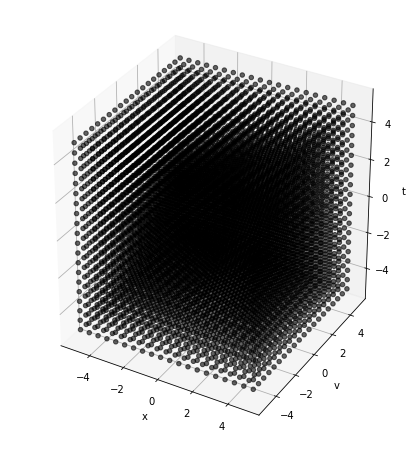

In [431]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = pts[:,0], ys = pts[:,1],zs = pts[:,2],alpha = .6,color = 'black')
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')

In [432]:
detJs = list()
bsize = 100

for i in range(0, len(pts), bsize):
    _, logdetJ = m(pts[i:i+bsize])
    detJs.append(torch.exp(logdetJ))
    i += bsize
detJs = torch.cat(detJs)

In [433]:
probs = list()

for i, pt in enumerate(pts): 
    probs.append(torch.exp(q0.log_prob(pt)) * detJs[i])
probs = torch.stack(probs).detach().numpy()

Text(0.5, 0, 't')

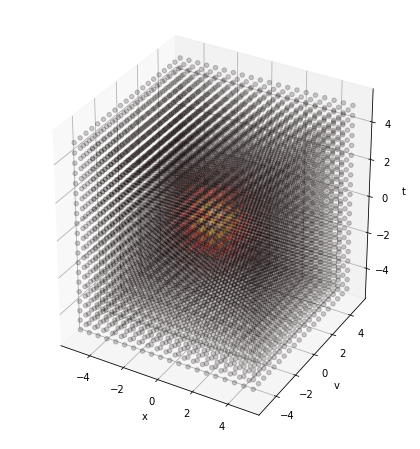

In [434]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.scatter(xs = pts[:,0], ys = pts[:,1],zs = pts[:,2], alpha=0.2, c=probs, cmap=plt.hot())
ax1.set_xlabel('x')
ax1.set_ylabel('v')
ax1.set_zlabel('t')